In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import tensorflow as tf
import pickle
%matplotlib inline

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Methods

## Newton-Raphson

In [3]:
def cons(x):
    return tf.constant(x, dtype=tf.float32)

In [4]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp]
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat

In [5]:
def compute_grads(fn, vars):
    grads = []
    for v in vars:
        grads.append(tf.gradients(fn, v)[0])
    return tf.reshape(tf.stack(grads), shape=[len(vars), -1])

In [6]:
def optimize(all_variables, update):
    optmize_variables = []
    for i in range(len(all_variables)):
        optmize_variables.append(all_variables[i].assign(all_variables[i] - tf.squeeze(update[i])))
    return tf.stack(optmize_variables)

In [7]:
def NewtonRaphson(x, f, num_iterations):
    hessian = compute_hessian(f, x)
    hessian_inv = tf.matrix_inverse(hessian)
    g = compute_grads(f, x)
    update = tf.unstack(tf.matmul(hessian_inv, g))
    optimize_op = optimize(x, update)

    sess = tf.Session()
    sess.run(tf.initialize_all_variables())

    func = np.inf
    history_loss = []
    for i in range(num_iterations):
        prev = func
        v, func = sess.run([x, f])
        history_loss.append(func)
        #print( v, func )
        sess.run(optimize_op)
    sess.close()
    return v, history_loss

### Test

In [8]:
x = []
for i in range( 2 ):
    x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
print(x)

f = tf.pow(x, 4) + 5

print(NewtonRaphson(x,f,10))

[<tf.Variable 'Variable:0' shape=() dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=() dtype=float32_ref>]
Instructions for updating:
Use `tf.global_variables_initializer` instead.
([0.080415, 0.09393187], [array([ 96.33424, 175.03459], dtype=float32), array([23.041327, 38.58707 ], dtype=float32), array([ 8.563718, 11.634483], dtype=float32), array([5.703944 , 6.3105154], dtype=float32), array([5.139051 , 5.2588673], dtype=float32), array([5.027467, 5.051134], dtype=float32), array([5.0054255, 5.0101004], dtype=float32), array([5.001072, 5.001995], dtype=float32), array([5.0002117, 5.0003943], dtype=float32), array([5.000042 , 5.0000777], dtype=float32)])


In [9]:
tf.reset_default_graph()

## Gradient Descent

In [10]:
def GradientDescent(X, f, num_iterations=100, lr=0.1):
    sess = tf.Session()
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(f)
    sess.run(tf.initialize_all_variables())
    X_opt = None
    history_loss = []
    for i in range(num_iterations):
        X_opt, _, cost = sess.run([X, optimizer, f])
        history_loss.append(cost)
    sess.close()
    return X_opt, history_loss

### Test

In [11]:
x = tf.get_variable("x", initializer=np.random.random(2) * 10.24 - 5.12)

f2 = tf.pow(x, 2) + 5

print(GradientDescent(x, f2, 10, 0.1))

(array([ 0.51086948, -0.21657335]), [array([27.63706968,  9.06827527]), array([19.48772449,  7.60369616]), array([14.2721436 ,  6.66636553]), array([10.93417186,  6.06647393]), array([8.79786996, 5.68254331]), array([7.43063676, 5.43682771]), array([6.55560751, 5.27956974]), array([5.9955888 , 5.17892463]), array([5.63717683, 5.11451176]), array([5.40779317, 5.07328753])])


In [12]:
tf.reset_default_graph()

## Gradient Descent With Momentum

In [13]:
def GradientDescentWithMomentum(X, f, num_iterations=100, lr=0.1, betha=0.4):
    sess = tf.Session()
    optimizer = tf.train.MomentumOptimizer(learning_rate=lr, momentum=betha).minimize(f)
    sess.run(tf.initialize_all_variables())
    X_opt = None
    history_loss = []
    for i in range(num_iterations):
        X_opt, _, cost = sess.run([X, optimizer, f])
        history_loss.append(cost)
        #print(X_opt, cost)
    sess.close()
    return X_opt, history_loss

### Test

In [14]:
X1 = tf.get_variable("X1", initializer=np.random.random(2) * 10.24 - 5.12)

f3 = tf.pow(X1, 2) + 5

print(GradientDescentWithMomentum(X1, f3, 10, 0.1, 0.4))

(array([-0.05238128,  0.01263778]), [array([27.72925182,  6.32304458]), array([19.54672106,  5.84674852]), array([12.12789319,  5.41490677]), array([7.81624505, 5.16393051]), array([5.89468143, 5.05207842]), array([5.21509591, 5.01252049]), array([5.03175196, 5.00184825]), array([5.00080175, 5.00004667]), array([5.00139115, 5.00008098]), array([5.00314539, 5.00018309])])


In [15]:
tf.reset_default_graph()

## Hill Climbing

In [16]:
alpha = 2.0

def powerLawGenerator(x):
    dir = np.random.choice([-1,1])
    return dir * (1.0 - x)**(1 - alpha)

In [17]:
def checkConstraint(x, limits):
    x_min, x_max = limits
    for dim in x:
        if dim < x_min or dim > x_max:
            return False
    return True

In [18]:
def HillClimbingStep(x, f, limits, delta, powerLaw):
    n = len(x)
    y = np.array(x)
    fx = f(x)
    if not powerLaw:
        y += delta * np.random.randn(n)
    else:
        y += delta * powerLawGenerator(np.random.randn(n))
    if not checkConstraint(y, limits):
        return x
    fx_prime = f(y)
    return (y if fx_prime <= fx else x)

In [19]:
def HillClimbing(x, f, limits, num_iterations=100, delta=0.6, powerLaw=True):
    history_loss = []
    for i in range(num_iterations):
        x_next = HillClimbingStep(x, f, limits, delta, powerLaw)
        x = x_next
        history_loss.append(f(x))
        #print(x, f(x))
    return x, history_loss

### Test

In [20]:
X = np.random.random(2) * 10.24 - 5.12

f4 = lambda x: np.sum(x**2) + 5

print(HillClimbing(X, f4, (-5, 5)))

(array([0.08511007, 0.18493085]), [14.949469536031119, 14.949469536031119, 7.662028702075263, 7.662028702075263, 7.662028702075263, 7.662028702075263, 7.662028702075263, 6.981909273556643, 6.981909273556643, 6.981909273556643, 6.981909273556643, 6.981909273556643, 6.981909273556643, 6.981909273556643, 5.622579582928747, 5.622579582928747, 5.622579582928747, 5.622579582928747, 5.622579582928747, 5.622579582928747, 5.6144144688611775, 5.6144144688611775, 5.6144144688611775, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.4193546602436795, 5.086790869703147, 5.086790869703147, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209, 5.046881699464209,

## Simulated Annealing

In [21]:
def SimulatedAnnealing(x, f, limits, t_max=1000, delta=0.6, powerLaw=True):
    history_loss = []
    for t in range(1, t_max + 1):
        T = t / t_max
        x_next = np.array(x)
        if not powerLaw:
            x_next += delta * np.random.randn(len(x))
        else:
            x_next += delta * powerLawGenerator(np.random.randn(len(x)))
        DE = f(x_next) - f(x)
        q = min(1,np.exp(-DE/T))
        if checkConstraint(x_next, limits) and DE < 0:
            x = x_next
        elif checkConstraint(x_next, limits) and T != 0 and np.random.random() < q:
            x = x_next
        #print(x, f(x))
        history_loss.append(f(x))
    return x, history_loss

### Test

In [22]:
X = np.random.random(2) * 10.24 - 5.12

f4 = lambda x: np.sum(x**2) + 5

print(SimulatedAnnealing(X, f4, (-5.0, 5.0), t_max=100, delta=1, powerLaw=False))

(array([-0.10204548, -0.44766642]), [8.172747406785579, 8.172747406785579, 7.118192440796314, 6.825804683877341, 6.825804683877341, 5.109324649229637, 5.109324649229637, 5.109324649229637, 5.015770567735356, 5.015770567735356, 5.015770567735356, 5.015770567735356, 5.015770567735356, 5.015770567735356, 5.015770567735356, 5.148134748473685, 5.148134748473685, 5.148134748473685, 5.148134748473685, 5.148134748473685, 5.148134748473685, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.255835570879247, 5.05392605571555, 5.4144051853195565, 5.4144051853195565, 5.3329225757149255, 5.273034527369054, 5.077554985341464, 5.077554985341464, 5.077554985341464, 5.077554985341464, 5.077554985341464, 5.077554985341464, 5.077554985341464, 5.077554985341464, 5.376620085983706, 5.252045051126356, 5.252045051126356, 5.252045051126356, 5.046323285759496, 5.046323285759496, 5.576480914

# Global Variables

In [23]:
num_experiments = 30

In [24]:
def standarDeviation(x):
    return np.sqrt(np.sum((x-np.median(x))**2)/len(x))

In [25]:
def getErrorPlot(data, num_steps=100):
    x = list(range(0, data.shape[1], num_steps))
    y = np.empty(0)
    std = np.empty(0)
    for j in range(0, data.shape[1], num_steps):
        xj = data[:, j]
        y = np.append(y, np.median(xj))
        std = np.append(std, standarDeviation(xj))
    return x, y, std

In [26]:
def plotGraphs(graph):
    plt.plot(list(range(1,1001)), np.average(graph, axis=0), label='Average')
    plt.plot(list(range(1,1001)), np.median(graph, axis=0), label='Median')
    plt.plot(list(range(1,1001)), np.min(graph, axis=0), label='Min')
    plt.plot(list(range(1,1001)), np.max(graph, axis=0), label='Max')
    x, y, z = getErrorPlot(graph)
    plt.errorbar(x, y, z, marker='^', ls='None')
    plt.legend(loc='upper right', shadow=True, fontsize = "xx-small")
    plt.xlabel('iterations')
    plt.ylabel('f(x)')

In [27]:
def plotGraphs10D(graph):
    plt.plot(list(range(1,10001)), np.average(graph, axis=0), label='Average')
    plt.plot(list(range(1,10001)), np.median(graph, axis=0), label='Median')
    plt.plot(list(range(1,10001)), np.min(graph, axis=0), label='Min')
    plt.plot(list(range(1,10001)), np.max(graph, axis=0), label='Max')
    x, y, z = getErrorPlot(graph, num_steps=1000)
    plt.errorbar(x, y, z, marker='^', ls='None')
    plt.legend(loc='upper right', shadow=True, fontsize = "xx-small")
    plt.xlabel('iterations')
    plt.ylabel('f(x)')

# Rastrigin
On an n-dimensional domain it is defined by:
$$f(x) = Ad + \sum_{i=1}^{d}x_i-Acos(2\pi x_i)$$

In [42]:
def Rastrigin(x):
    A = 10
    d = len(x)
    return A * d + np.sum(x**2 - A * np.cos(2*np.pi*x))

def RastriginTF(x):
    A = 10
    d = len(x)
    return A * d + tf.reduce_sum(tf.pow(x, 2) - A * tf.cos([2 * np.pi * xi for xi in x]))

## Plotting

In [43]:
def RastriginPlot(x, y):
    return 20 + (x**2 - 10 * np.cos(2*np.pi*x)) + (y**2 - 10 * np.cos(2*np.pi*y))

x = np.linspace(-5.12, 5.12, 400)
y = np.linspace(-5.12, 5.12, 400)
X, Y = np.meshgrid(x, y)
Z = RastriginPlot(X,Y)

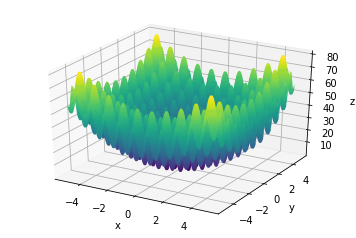

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 100)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Rastrigin with Newton-Raphson

### 2-Dimensions  

In [223]:
sess = tf.Session()
optimal_found1 = []

total_history = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found1.append(optimum)
    
total_history = np.array(total_history)
print(total_history.shape)
sess.close()

(30, 1000)


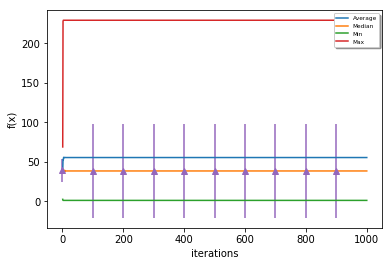

In [224]:
plotGraphs(total_history)

In [180]:
print("Optimal founds:")
for x in optimal_found1:
    print(Rastrigin(np.array(x)))

Optimal founds:
38.180702209472656
31.838485717773438
9.94955825805664
35.236440658569336
40.50254440307617
25.868680953979492
16.914201736450195
30.261672019958496
72.66572570800781
23.256418228149414
0.9949588775634766
26.241291046142578
48.54330062866211
15.919242858886719
80.70657348632812
52.56371307373047
44.522918701171875
26.281841278076172
49.30788612365723
49.30788612365723
41.34824562072754
52.56371307373047
54.57389831542969
38.180702209472656
927.4930419921875
46.53311347961426
0.9949588775634766
153.07833862304688
72.66572570800781
33.30739784240723


In [177]:
tf.reset_default_graph()

### 10-Dimensions

In [ ]:
sess = tf.Session()
optimal_found21 = []

total_history21 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history21.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found21.append(optimum)
    
total_history21 = np.array(total_history21)
print(total_history21.shape)
sess.close()

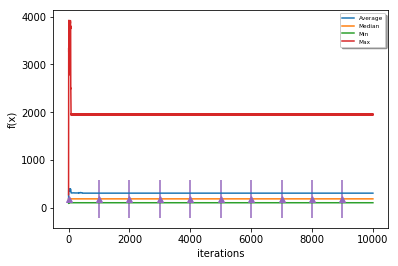

In [188]:
plotGraphs10D(total_history21)

In [95]:
print("Optimal founds:")
for x in optimal_found21:
    print(Rastrigin(np.array(x)))

Optimal founds:
199.64142608642578
146.9358139038086
114.99582195281982
243.68328857421875
142.91526412963867
229.56434631347656
141.62904739379883
140.13976287841797
146.5834197998047
218.70804595947266
107.59786415100098
1299.33837890625
170.62559509277344
263.1091766357422
723.8820190429688
200.6363754272461
278.7104034423828
346.8373718261719
172.51319885253906
138.35369110107422
164.6620864868164
1953.252197265625
177.33938598632812
226.3244400024414
265.557861328125
149.23715209960938
153.13595962524414
170.91597747802734
318.2976989746094
225.27981567382812


In [96]:
tf.reset_default_graph()

## Rastrigin with Gradient Descent

### 2-Dimensions

In [ ]:
sess = tf.Session()
optimal_found2 = []

total_history2 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history2.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found2.append(optimum)
    
total_history2 = np.array(total_history2)
print(total_history2.shape)
sess.close()

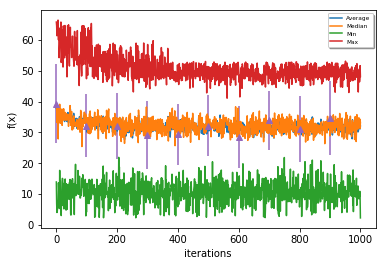

In [189]:
plotGraphs(total_history2)

In [89]:
print("Optimal founds:")
for x in optimal_found2:
    print(Rastrigin(np.array(x)))

Optimal founds:
43.87887763977051
40.17009162902832
4.395713806152344
39.79482841491699
32.74654483795166
27.626662731170654
44.834678649902344
25.733779907226562
29.194660186767578
48.36265754699707
26.43130874633789
27.35896873474121
35.586710929870605
35.529022216796875
39.29043006896973
20.33817768096924
29.096915245056152
19.37247347831726
27.11729621887207
14.275048732757568
28.744909286499023
34.495633125305176
35.8014612197876
44.10295867919922
40.21110725402832
14.019403457641602
23.46574854850769
29.137435913085938
32.45532035827637
26.03416681289673


### 10-Dimensions

In [37]:
sess = tf.Session()
optimal_found22 = []

total_history22 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescent(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history22.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found22.append(optimum)
    
total_history22 = np.array(total_history22)
print(total_history22.shape)
sess.close()

(30, 10000)


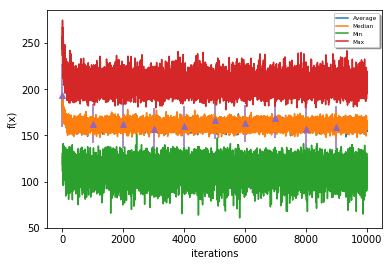

In [193]:
plotGraphs10D(total_history22)

In [36]:
print("Optimal founds:")
for x in optimal_found22:
    print(Rastrigin(np.array(x)))

Optimal founds:
164.96483612060547
163.44109344482422
161.04362106323242
152.66156387329102
168.1599884033203
143.34291458129883
139.5222511291504
183.03375244140625
134.8170166015625
158.78728103637695
141.59908294677734
108.96165752410889
189.9513397216797
186.17536163330078
154.7824592590332
173.5322036743164
183.2177734375
160.92097854614258
190.46197509765625
131.9676170349121
127.50622749328613
146.08081817626953
168.9621353149414
157.50615310668945
183.50868225097656
171.4989242553711
162.52804565429688
160.09414672851562
176.80121612548828
146.78627014160156


In [37]:
tf.reset_default_graph()

## Rastrigin with Momentum

### 2-Dimensions

In [73]:
sess = tf.Session()
optimal_found3 = []

total_history3 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())

    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history3.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found3.append(optimum)
    
total_history3 = np.array(total_history3)
print(total_history3.shape)
sess.close()

(30, 1000)


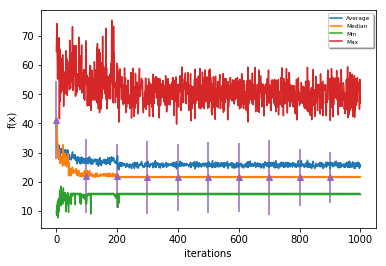

In [194]:
plotGraphs(total_history3)

In [39]:
print("Optimal founds:")
for x in optimal_found3:
    print(Rastrigin(np.array(x)))

Optimal founds:
16.054221391677856
45.58212471008301
41.51041793823242
21.124197840690613
16.054223775863647
19.249613285064697
35.52626132965088
24.146577835083008
16.282244205474854
16.282246589660645
21.869359254837036
53.53273391723633
21.109208583831787
48.96734046936035
24.304597854614258
16.282244205474854
23.614449977874756
21.64133644104004
18.84697914123535
18.15683114528656
38.345319747924805
22.27199101448059
17.928808212280273
43.470726013183594
34.48457145690918
24.146577835083008
18.15683114528656
21.337231397628784
18.618956327438354
19.249610900878906


### 10-Dimensions

In [85]:
sess = tf.Session()
optimal_found23 = []

total_history23 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 10.24 - 5.12))
        
    sess.run(tf.initialize_all_variables())
    
    f1 = RastriginTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history23.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found23.append(optimum)
    
total_history23 = np.array(total_history23)
print(total_history23.shape)
sess.close()

(30, 10000)


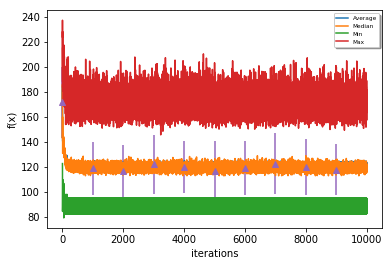

In [195]:
plotGraphs10D(total_history23)

In [87]:
print("Optimal founds:")
for x in optimal_found23:
    print(Rastrigin(np.array(x)))

Optimal founds:
99.29209661483765
144.41814041137695
87.94424247741699
119.15935325622559
115.9575424194336
132.45343017578125
89.73769474029541
102.6936469078064
156.43847274780273
142.47405242919922
121.87905502319336
115.94523334503174
126.62247276306152
138.11521911621094
152.72478103637695
134.96770095825195
171.0356674194336
115.56133365631104
122.93380928039551
103.61789679527283
93.12934589385986
118.22324752807617
110.21722888946533
127.30320167541504
103.36214303970337
98.29881715774536
82.65515518188477
116.01677703857422
140.98926162719727
158.22586822509766


In [88]:
tf.reset_default_graph()

## Rastrigin with Hill-Climbing

### 2-Dimensions

In [77]:
optimal_found4 = []
total_history4 = []

for i in range(num_experiments):
    x = np.random.random(2) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = HillClimbing(x, f, (-5.12,5.12), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history4.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found4.append(optimum)

total_history4 = np.array(total_history4)
print(total_history4.shape)

(30, 1000)


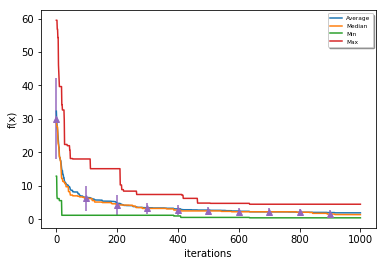

In [196]:
plotGraphs(total_history4)

In [48]:
print("Optimal founds:")
for x in optimal_found4:
    print(Rastrigin(np.array(x)))

Optimal founds:
1.277248569821296
1.2713212861596688
2.268107833903926
1.1428137756336199
1.2242145586294981
1.240925410770906
2.865720081942328
2.56470616616096
1.4181255070608927
1.0351103190609052
2.50767591080103
1.2330108226990433
4.538272053766098
3.0768754460006065
0.6016028596680627
2.797540746717285
0.9959736285290077
1.8926494685121682
1.3221001286675573
1.0727811436629437
1.26992644314209
0.47856180084635724
1.4420308793511154
1.1405609917780595
1.7388196253231953
4.145320613407801
3.2007116734868077
2.279024289503262
3.756959481973521
3.1844562117708506


### 10-Dimensions

In [89]:
optimal_found24 = []
total_history24 = []

for i in range(num_experiments):
    x = np.random.random(10) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = HillClimbing(x, f, (-5.12,5.12), num_iterations=10000)
    #total_history += np.array(history_loss)
    total_history24.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found24.append(optimum)

total_history24 = np.array(total_history24)
print(total_history24.shape)

(30, 10000)


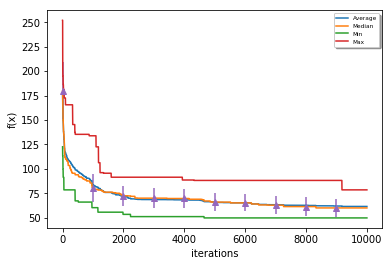

In [197]:
plotGraphs10D(total_history24)

In [91]:
print("Optimal founds:")
for x in optimal_found24:
    print(Rastrigin(np.array(x)))

Optimal founds:
56.82087435967602
52.98486425314493
51.00121768596045
57.91280902158795
73.55501480517715
53.301480011895066
60.16943890573872
62.08516648924095
62.353044361169026
72.25037928549841
71.01316150204498
51.082316814640535
49.743145539219036
76.55062095417031
56.545003005263894
65.82483632661075
54.557265384820035
75.69770221458919
72.14661037398614
56.32639971617346
59.614152143215456
63.56901173206613
64.29478866108195
78.38884543381504
49.665756358258015
51.9872588733466
55.540429568325244
63.0727690097618
65.62298401921561
58.966180326109814


## Rastrigin with Simulated Annealing

### 2-Dimensions

In [61]:
optimal_found5 = []
total_history5 = []

for i in range(num_experiments):
    x = np.random.random(2) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = SimulatedAnnealing(x, f, (-5.12,5.12), t_max=1000, delta=1)
    #total_history += np.array(history_loss)
    total_history5.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found5.append(optimum)

total_history5 = np.array(total_history5)
print(total_history5.shape)

/home/ofnanezn/deepspeech-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


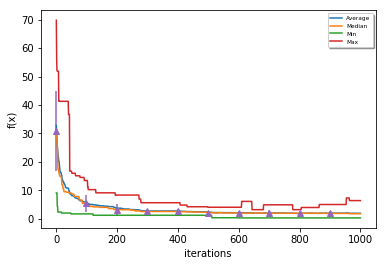

In [198]:
plotGraphs(total_history5)

In [63]:
print("Optimal founds:")
for x in optimal_found5:
    print(Rastrigin(np.array(x)))

Optimal founds:
2.2374460301800134
1.8995524960173995
5.189559022903371
1.7100511071378008
0.2750994572843304
1.627192880522287
0.8771177424520111
2.6581130565470694
1.0530549885179568
2.4220147338740716
3.899507271768968
3.0200135128397
1.4289411654060444
0.7677895908403904
0.2283319257372156
3.095915947402112
1.3898728309195363
3.56729917395435
0.9391428368410217
1.097795736151454
1.5922141455756602
2.1509327981315423
3.2877658315986196
2.111938465523483
1.4584792153279622
1.8222500625714204
6.307612399806869
2.1597040625077213
1.3485147534491801
1.5184924564537106


### 10-Dimensions

In [100]:
optimal_found25 = []
total_history25 = []

for i in range(num_experiments):
    x = np.random.random(10) * 10.24 - 5.12
    f = Rastrigin
    optimum, history_loss = SimulatedAnnealing(x, f, (-5.12,5.12), t_max=10000)
    #total_history += np.array(history_loss)
    total_history25.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found25.append(optimum)

total_history25 = np.array(total_history25)
print(total_history25.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 10000)


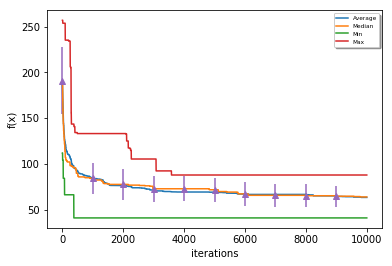

In [199]:
plotGraphs10D(total_history25)

In [102]:
print("Optimal founds:")
for x in optimal_found25:
    print(Rastrigin(np.array(x)))

Optimal founds:
59.145278976814446
55.887873524920764
76.77103894217849
69.20793770165606
75.87348408826729
60.267129048240065
55.7036295110125
68.8484552334337
57.03870981704921
63.92985711495767
77.37486313054102
76.23515761123768
46.39155919696445
65.63081061773097
59.47674339230706
66.05220530318908
64.69713539707098
58.39162941080513
64.46779798667895
60.915605795493164
69.25348493834993
63.628279695571756
48.232033709546116
87.77533373144763
53.18402231915342
72.34129128693773
40.821478347092864
79.1645521837118
42.74669703042928
58.153946354826665


# Rosenbrock

In [49]:
def Rosenbrock(x):
    return 100 * (x[0]**2-x[1])**2 + (1-x[0])**2

def RosenbrockTF(x):
    return 100 * tf.pow(tf.pow(x[0]-tf.pow(x[1], 2), 2), 2) + tf.pow(1-x[0], 2) 

## Rosenbrock with Newton-Raphson

In [ ]:
sess = tf.Session()
optimal_found6 = []

total_history6 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 4.096 - 2.048))
        
    sess.run(tf.initialize_all_variables())

    f1 = RosenbrockTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history6.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found6.append(optimum)
    
total_history6 = np.array(total_history6)
print(total_history6.shape)
sess.close()

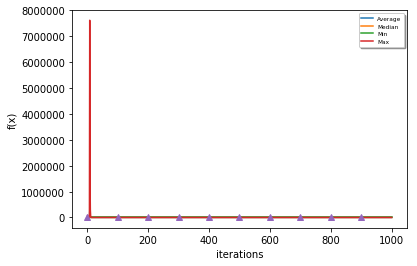

In [200]:
plotGraphs(total_history6)

In [86]:
print("Optimal founds:")
for x in optimal_found6:
    print(Rosenbrock(np.array(x)))

Optimal founds:
0.7711096853441534
0.7711096853441534
1.4210854715202004e-12
1.4210854715202004e-12
0.7711096853441534
1.4210854715202004e-12
1.4210854715202004e-12
400.00004768371724
1.4210854715202004e-12
400.00004768371724
400.00004768371724
1.4210854715202004e-12
1.4210854715202004e-12
0.7711096853441557
1.4210854715202004e-12
400.00004768371724
1.4210854715202004e-12
1.4210854715202004e-12
400.00004768371724
1.4210854715202004e-12
1.4210854715202004e-12
0.7711096853441534
400.00004768371724
400.00004768371724
1.4210854715202004e-12
0.7711096853441534
400.00004768371724
1.4210854715202004e-12
400.00004768371724
1.4210854715202004e-12


## Rosenbrock with Gradient Descent

In [190]:
sess = tf.Session()
optimal_found7 = []

total_history7 = []


for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 3.0 - 1.5))
        
    sess.run(tf.initialize_all_variables())

    f1 = RosenbrockTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history7.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found7.append(optimum)
    
total_history7 = np.array(total_history7)
print(total_history7.shape)
sess.close()

(30, 1000)


/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 997 results
  r = func(a, **kwargs)
/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


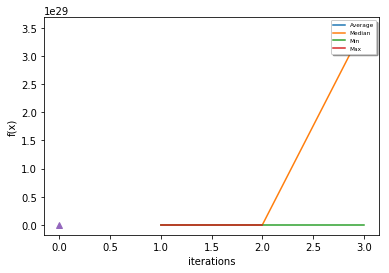

In [191]:
plotGraphs(total_history7)

In [192]:
print("Optimal founds:")
for x in optimal_found7:
    print(Rosenbrock(np.array(x)))

Optimal founds:
nan
nan
nan
0.000987592004879201
nan
nan
nan
nan
0.0011481795187974712
nan
nan
0.0012092813734750922
0.0010723994206635926
nan
0.0012747751583491698
nan
nan
nan
nan
0.0012691204220638633
nan
401.4042778773695
nan
nan
398.55922708515504
nan
398.44897563217376
nan
nan
nan


## Rosenbrock with Momentum

In [119]:
sess = tf.Session()
optimal_found8 = []

total_history8 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 4.096 - 2.048))
        
    sess.run(tf.initialize_all_variables())

    f1 = RosenbrockTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history8.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found8.append(optimum)
    
total_history8 = np.array(total_history8)
print(total_history8.shape)
sess.close()

(30, 1000)


/home/ofnanezn/deepspeech-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median for 997 results
  r = func(a, **kwargs)
/home/ofnanezn/deepspeech-venv/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


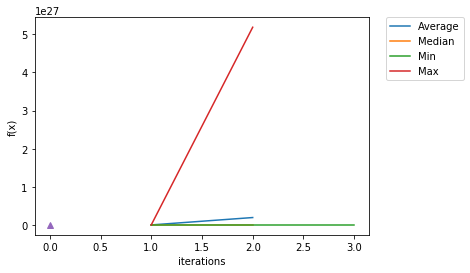

In [89]:
plotGraphs(total_history8)

In [90]:
print("Optimal founds:")
for x in optimal_found8:
    print(Rosenbrock(np.array(x)))

Optimal founds:
nan
0.0005040335165299186
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.0005749337120746844
nan
nan
nan
nan
nan
nan
nan
398.9674805671066
nan
nan
nan
nan
nan
nan
nan
nan


## Rosenbrock with Hill-Climbing

In [127]:
optimal_found9 = []
total_history9 = []

for i in range(num_experiments):
    x = np.random.random(2) * 4.096 - 2.48
    f = Rosenbrock
    optimum, history_loss = HillClimbing(x, f, (-2.048,2.048), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history9.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found9.append(optimum)

total_history9 = np.array(total_history9)
print(total_history9.shape)

(30, 1000)


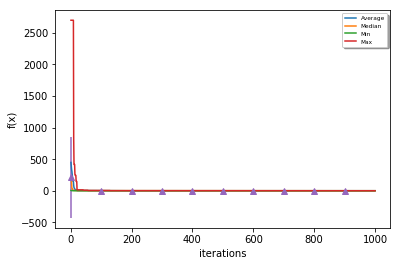

In [201]:
plotGraphs(total_history9)

In [91]:
print("Optimal founds:")
for x in optimal_found9:
    print(Rosenbrock(np.array(x)))

Optimal founds:
0.002685143795012273
0.05534042404520613
0.012421963789456567
0.011402417054536181
0.02825517892941205
0.03566655921862947
0.02933824964002627
0.004340338636597912
0.008083864050835048
0.012459979811081434
0.03745709305344968
0.01213482920412181
0.02634905288331008
0.02420337207443383
0.04952673817416602
0.02395764103760262
0.010457549045358236
0.008196757881769578
0.009819175624649148
0.03558382568308974
0.01606873632597822
0.06668291758229411
0.01000099501827673
0.00762562977899908
0.019285969287823484
0.008355843551068158
0.016541549014543338
0.0034714280318286473
0.02921915637120365
0.0018328792215759275


## Rosenbrock with Simulated Annealing

In [110]:
optimal_found10 = []
total_history10 = []

for i in range(num_experiments):
    x = np.random.random(2) * 4.096 - 2.048
    f = Rosenbrock
    optimum, history_loss = SimulatedAnnealing(x, f, (-2.048,2.048), t_max=1000)
    #total_history += np.array(history_loss)
    total_history10.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found10.append(optimum)

total_history10 = np.array(total_history10)
print(total_history10.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


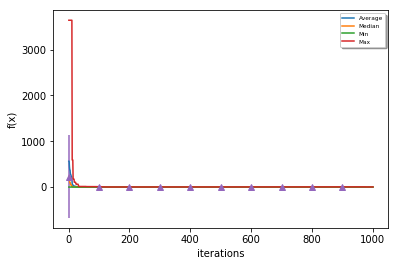

In [202]:
plotGraphs(total_history10)

In [93]:
print("Optimal founds:")
for x in optimal_found10:
    print(Rosenbrock(np.array(x)))

Optimal founds:
0.7394755324840284
2.072461240640256
1.1554498609323072
0.17172209581231632
1.8659563056415198
0.38697903975101455
1.4151150712499112
0.23515977187795437
0.1631138124837067
0.8429923021973557
0.11262848916778248
0.3334891506145581
3.4380350337750927
0.22888087375172209
0.2413614055531917
2.1307010708314476
0.9360931890145118
0.029590830550618407
1.43821176416307
0.30318231383361643
0.01845483260145386
2.801401008232098
4.174196062804733
0.7644599057663524
0.1173262978838137
0.1685250410767283
2.1308781150175333
0.32270362632824945
1.7770291346240237
0.4278600141282882


# Schwefel

In [57]:
def Schwefel(x):
    d = len(x)
    return 418.9829 * d + np.sum(-x * np.sin(np.sqrt(np.abs(x))))

def SchwefelTF(x):
    d = len(x)
    return 418.9829 * d + tf.reduce_sum(tf.multiply(tf.negative(x), tf.sin([tf.sqrt(abs(xi)) for xi in x])))

## Schwefel with Newton-Raphson

### 2-Dimensions

In [166]:
sess = tf.Session()
optimal_found11 = []

total_history11 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history11.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found11.append(optimum)
    
total_history11 = np.array(total_history11)
print(total_history11.shape)
sess.close()

(30, 1000)


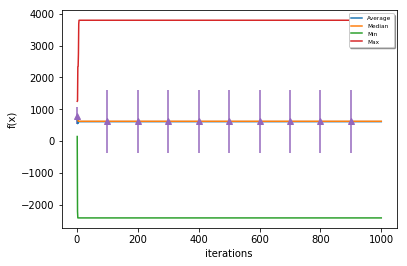

In [203]:
plotGraphs(total_history11)

In [58]:
print("Optimal founds:")
for x in optimal_found11:
    print(Schwefel(np.array(x)))

Optimal founds:
245.78220624999994
956.4041544921874
1260.8939616210937
482.61789960937494
434.27939863281244
-2419.02882890625
620.826166821289
2347.061747265625
620.8261210449218
956.8966776855468
1074.8753764160156
0.00010175781244470272
1063.8919779785156
118.43833417968744
-671.137959765625
1134.5650431640624
719.5274455078124
335.5780436523437
3798.853739453125
865.994063092041
572.4876200683593
758.998758984375
394.8999430664062
837.9657694824218
936.6671244628906
-839.891621875
719.5274760253906
601.0562388427734
0.00010175781244470272
355.34791059570307


### 10-Dimensions

In [51]:
sess = tf.Session()
optimal_found26 = []

total_history26 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history26.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found26.append(optimum)
    
total_history26 = np.array(total_history26)
print(total_history26.shape)
sess.close()

(30, 10000)


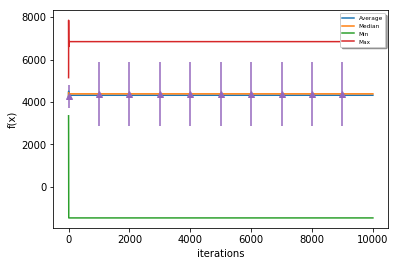

In [204]:
plotGraphs10D(total_history26)

In [53]:
print("Optimal founds:")
for x in optimal_found26:
    print(Schwefel(np.array(x)))

Optimal founds:
3863.037618164062
2928.4425253906247
1535.9867148437497
4909.356404785156
3989.4227042236325
6034.503560546875
9857.54384375
4407.0005698242185
3382.910359863281
3334.144795898437
2384.618672851562
2601.214620117187
6359.305318359375
3156.509297851562
3599.6969199218747
3262.459981445312
2788.2013144531247
2485.284688476562
4850.161824707031
5018.87343359375
4102.618855957031
4683.219380859375
4486.059285644531
4200.7354331054685
4878.2200522460935
4443.952275756836
4167.459060195923
3895.8628439941403
4012.802175048828
2404.385030273437


In [54]:
tf.reset_default_graph()

## Schwefel with Gradient Descent

### 2-Dimensions

In [119]:
sess = tf.Session()
optimal_found12 = []

total_history12 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history12.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found12.append(optimum)
    
total_history12 = np.array(total_history12)
print(total_history12.shape)
sess.close()

(30, 1000)


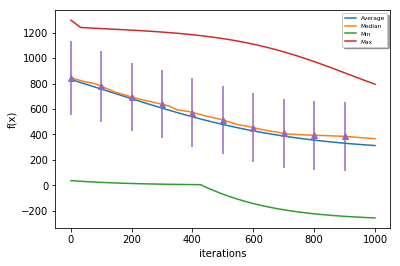

In [205]:
plotGraphs(total_history12)

In [56]:
print("Optimal founds:")
for x in optimal_found12:
    print(Schwefel(np.array(x)))

Optimal founds:
1196.4262187011718
1623.4280802734374
1764.6685587890624
1405.6649577148437
1533.464579296875
882.112055493164
1158.2392069824218
1275.9534708984374
1097.197275830078
937.7036616333007
1675.684305859375
1932.9952189453124
1307.4253947265624
1197.1666666992187
1280.7854411132812
1670.53855390625
1353.8518473632812
1333.5457560546874
1312.1566264160156
1556.9900309570312
1202.0961100585937
1144.9664408691406
1650.195536328125
1763.3749796875
1547.6785685546874
963.2505671508789
1222.554697705078
1534.7821452148437
1249.1051432617187
1138.9141642578124


### 10-Dimensions

In [59]:
sess = tf.Session()
optimal_found27 = []

total_history27 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history27.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found27.append(optimum)
    
total_history27 = np.array(total_history27)
print(total_history27.shape)
sess.close()

(30, 10000)


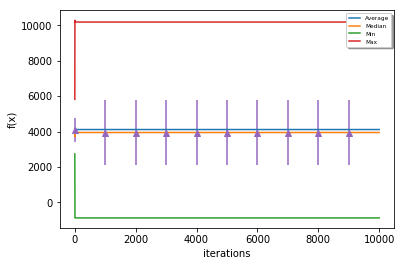

In [206]:
plotGraphs10D(total_history27)

In [61]:
print("Optimal founds:")
for x in optimal_found27:
    print(Schwefel(np.array(x)))

Optimal founds:
4672.907643798828
2976.6685996093747
6387.886373046875
4098.229291442871
10179.6483359375
5716.601827148437
4573.653615478515
4505.7178549804685
5087.020528320312
5453.249166015625
3518.1476035156247
3647.9810996093747
3519.183614257812
3382.4918417968747
4712.5354819335935
6262.501119140625
2840.7096152343747
2869.3678183593747
4593.468709472656
4850.148091796875
-870.8668007812503
2524.815450195312
3520.7562460937497
2711.3028769531247
5095.920857910156
1782.9710898437497
3349.981648925781
3794.9290366210935
4564.9676108398435
3134.738790039062


## Schwefel with Momentum

### 2-Dimensions

In [174]:
sess = tf.Session()
optimal_found13 = []

total_history13 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history13.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found13.append(optimum)
    
total_history13 = np.array(total_history13)
print(total_history13.shape)
sess.close()

(30, 1000)


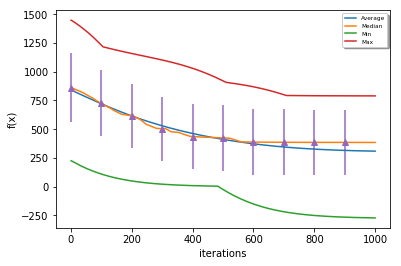

In [207]:
plotGraphs(total_history13)

In [104]:
print("Optimal founds:")
for x in optimal_found13:
    print(Schwefel(np.array(x)))

Optimal founds:
-271.40273027343756
572.5292765625
-19.009785937500055
238.1217448242187
790.0074946411132
118.46287031249994
437.2905680664062
513.4791056640624
158.3508708007812
414.7865397460937
79.14036054687494
355.5138346679687
604.9188029296874
79.18137617187494
414.5981852539062
572.544169140625
16.711588574218695
421.83716840820307
-134.3827717773438
513.3558451660156
0.0588175781249447
519.4983622558593
485.5504557617187
-17.370076464843805
652.7414652832031
473.81873579101557
118.5101725585937
218.09690351562494
159.0319010742187
789.8721110351562


### 10-Dimensions

In [105]:
sess = tf.Session()
optimal_found28 = []

total_history28 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 1024 - 512))
        
    sess.run(tf.initialize_all_variables())

    f1 = SchwefelTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history28.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found28.a--ppend(optimum)
    
total_history28 = np.array(total_history28)
print(total_history28.shape)
sess.close()

(30, 10000)


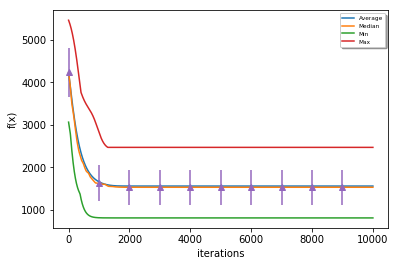

In [208]:
plotGraphs10D(total_history28)

In [108]:
print("Optimal founds:")
for x in optimal_found28:
    print(Schwefel(np.array(x)))

Optimal founds:
1915.2835898437497
2408.9046835937497
1184.4344687499997
1520.0772910156247
1835.8570761718747
1697.7765097656247
1303.3363242187497
1520.0750937499997
1144.9915976562497
1441.5296835937497
809.4725546874997
829.0863242187497
1223.9095664062497
2073.3387656249997
1085.7303671874997
1598.9915976562497
1638.6073203124997
2053.6937460937497
1579.7054648437497
1875.4090781249997
2467.6224570312497
1599.2730917968747
1441.0489707031247
1460.9107871093747
1046.2581992187497
1599.5638632812497
1243.7562460937497
1539.8302207031247
1362.2264609374997
2251.0782675781247


## Schwefel with Hill-Climbing

### 2-Dimensions

In [109]:
optimal_found14 = []
total_history14 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1024 - 512
    f = Schwefel
    optimum, history_loss = HillClimbing(x, f, (-512, 512), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history14.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found14.append(optimum)

total_history14 = np.array(total_history14)
print(total_history14.shape)

(30, 1000)


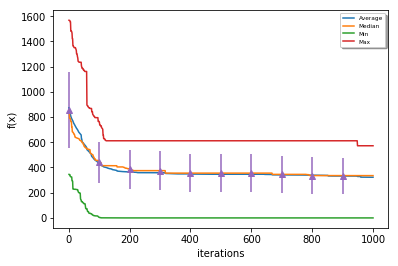

In [209]:
plotGraphs(total_history14)

In [133]:
print("Optimal founds:")
for x in optimal_found14:
    print(Schwefel(np.array(x)))

Optimal founds:
333.0332776779435
411.5896049378566
236.8832848691627
296.1092699103367
513.340853934139
335.58670204386914
414.5473644136664
236.8797257838237
296.10782442597156
434.2819149764907
217.14375536230318
513.2747017493243
296.10859612174306
414.54767256490254
335.5820429977458
118.44414627137212
414.54844537116935
411.5967350962328
0.008391754568378929
0.0017602216021259665
118.43980781751793
414.54680641747285
474.64029958383344
118.52316507826265
296.11080314764786
296.1081369313081
471.5080624643648
572.4904536543007
335.5804462209681
355.3552646015568


### 10-Dimensions

In [112]:
optimal_found29 = []
total_history29 = []

for i in range(num_experiments):
    x = np.random.random(10) * 1024 - 512
    f = Schwefel
    optimum, history_loss = HillClimbing(x, f, (-512, 512), num_iterations=10000)
    #total_history += np.array(history_loss)
    total_history29.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found29.append(optimum)

total_history29 = np.array(total_history29)
print(total_history29.shape)

(30, 10000)


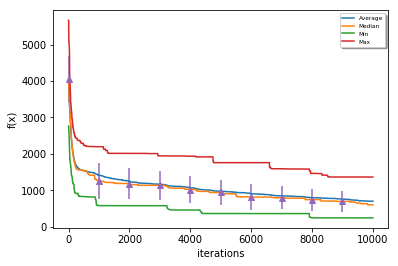

In [210]:
plotGraphs10D(total_history29)

In [115]:
print("Optimal founds:")
for x in optimal_found29:
    print(Schwefel(np.array(x)))

Optimal founds:
474.37090374392665
594.9048797645337
592.3327381932995
809.1188693543095
772.5488281803036
1114.2956856339742
1048.3649256162103
237.04694563368366
793.5109921732101
474.0080680804185
1250.6466167787298
473.9655116734398
1243.5436238076845
237.27727668383932
475.6202570112464
577.7690992283228
572.5532524223554
1362.5185708563517
597.6436986272988
703.729116044834
591.8877185947836
356.5853073137755
590.5586345772508
694.3953695555924
691.6503911414547
709.6661169925046
691.075149057734
592.3700874282345
573.0884116930315
1027.6793935367791


## Schwefel with Simulated Annealing

### 2-Dimensions

In [138]:
optimal_found15 = []
total_history15 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1024 - 512
    f = Schwefel
    optimum, history_loss = SimulatedAnnealing(x, f, (-512, 512), t_max=1000)
    #total_history += np.array(history_loss)
    total_history15.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found15.append(optimum)

total_history15 = np.array(total_history15)
print(total_history15.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


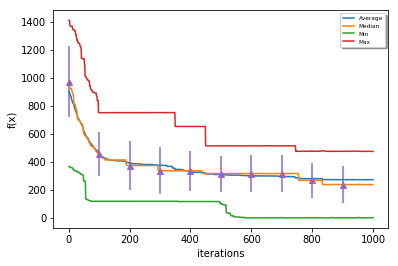

In [211]:
plotGraphs(total_history15)

In [140]:
print("Optimal founds:")
for x in optimal_found15:
    print(Schwefel(np.array(x)))

Optimal founds:
237.50768904247752
237.11017688739616
411.6348883015917
122.07313208086475
218.25779717970227
115.21017737722423
335.7981225204969
338.7795262121846
118.83020433892625
217.1874206427026
413.4628020043463
234.17600391348458
118.94297518271424
474.28022328949453
1.4338054264860602
474.01496200517454
434.6757832335326
336.481416296233
221.83804380307458
437.2047052935801
335.77676675036224
298.29736801577405
336.3197730813697
335.6265493552564
218.75495413421766
237.5955735063767
119.21946718582308
220.83993070144152
470.7933003468506
118.64509110926247


### 10-Dimensions

In [116]:
optimal_found30 = []
total_history30 = []

for i in range(num_experiments):
    x = np.random.random(10) * 1024 - 512
    f = Schwefel
    optimum, history_loss = SimulatedAnnealing(x, f, (-512, 512), t_max=10000)
    #total_history += np.array(history_loss)
    total_history30.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found30.append(optimum)

total_history30 = np.array(total_history30)
print(total_history30.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 10000)


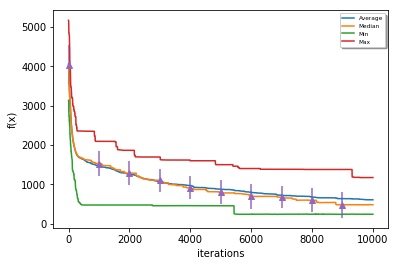

In [212]:
plotGraphs10D(total_history30)

In [119]:
print("Optimal founds:")
for x in optimal_found30:
    print(Schwefel(np.array(x)))

Optimal founds:
887.5051570862356
1051.0216833585328
478.27751560011575
480.46049926965634
452.2033595570656
366.2668506063874
1173.5487470304993
479.70729550703527
597.1049742299633
240.90049000533054
990.6823778261892
334.85964842803105
1145.9845081364128
478.492675498223
810.4402845239852
473.1420124975516
241.17460775609698
361.17588180669554
934.3375361049011
791.8905774337118
595.8986569632989
478.7243141524832
692.6354825645749
594.2585722989584
478.3918307830313
596.0245977812506
479.7883452123988
362.39524834155054
697.5221955080629
476.1509394189661


# Griewank

In [128]:
def Griewank(x):
    d = len(x)
    return 1 + np.sum(x**2 / 4000) - np.prod(np.cos(x/np.sqrt(np.arange(1,d+1))))

def GriewankTF(x):
    d = len(x)
    return 1 + tf.reduce_sum([xi**2/4000 for xi in x]) - tf.reduce_prod(tf.cos([x[i]/np.sqrt(i+1) for i in range(d)]))

## Griewank with Newton-Raphson

### 2-Dimensions

In [129]:
sess = tf.Session()
optimal_found16 = []

total_history16 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 1000)
    #total_history += np.array(history_loss)
    total_history16.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found16.append(optimum)
    
total_history16 = np.array(total_history16)
print(total_history16.shape)
sess.close()

(30, 1000)


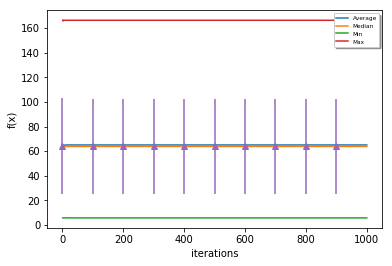

In [213]:
plotGraphs(total_history16)

In [131]:
print("Optimal founds:")
for x in optimal_found16:
    print(Griewank(np.array(x)))

Optimal founds:
38.19436015390311
16.053724703654552
18.843951688528826
72.35810088128336
143.0689544240672
63.5086423842819
20.937786730268716
66.91869597172492
80.56961933797207
64.12665338284609
62.32353559871692
5.816498165767383
69.32904734798772
22.677435161921906
39.53832535421251
115.45589211113791
78.13843941171851
139.72217981282867
56.93601406453483
86.00573893567183
22.76715060974571
40.15500398042644
74.55704384044957
166.27443560269208
65.68011122316308
94.67713414021993
56.15230141409982
60.69546624986356
92.97512420462895
16.714104788625225


### 10-Dimensions

In [152]:
sess = tf.Session()
optimal_found31 = []

total_history31 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = NewtonRaphson(x, f1, 10000)
    #total_history += np.array(history_loss)
    total_history31.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found31.append(optimum)
    
total_history31 = np.array(total_history31)
print(total_history31.shape)
sess.close()

(30, 10000)


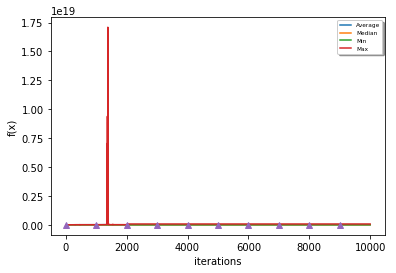

In [214]:
plotGraphs10D(total_history31)

In [154]:
print("Optimal founds:")
for x in optimal_found31:
    print(Griewank(np.array(x)))

Optimal founds:
1.001851785364826
1.0320632822892615
1.0061833443913244
1.008626661680048
1.0314655492589635
1.0345134506317897
1.162381077744317
1.0108239470239502
1.0276075312743693
1.4783448211320724
0.0
1.0105310581702487
1.0120772553233053
1.0240350240987688
0.3936426026103389
1.2244984961145775
0.0
6.870989036899533e+16
1.105448142329147
1.0055627808097027
1.1402441433906478
1.813024892776068
1.003706043685338
1.0166611338059215
1.0024692535333881
1.329930251323846
2.87045834569104
726049054785537.0
1.017901013706155
9717670597361664.0


In [155]:
tf.reset_default_graph()

## Griewank with Gradient Descent

### 2-Dimensions

In [143]:
sess = tf.Session()
optimal_found17 = []

total_history17 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = GradientDescent(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history17.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found17.append(optimum)
    
total_history17 = np.array(total_history17)
print(total_history17.shape)
sess.close()

(30, 1000)


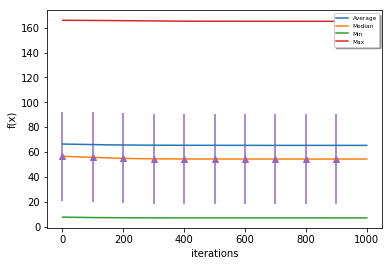

In [215]:
plotGraphs(total_history17)

In [145]:
print("Optimal founds:")
for x in optimal_found17:
    print(Griewank(np.array(x)))

Optimal founds:
54.506073617709
32.86117087973463
47.09753355527045
88.29192892919393
61.480775480404475
98.07864513581214
95.27900336856759
82.13265258196107
54.16596715522543
73.51797821250234
165.11923971694299
12.396127641402263
81.30545793263872
67.13889131808568
13.541163241030082
50.80942347671072
53.49419589913062
58.660567753858025
77.32885459054918
114.65051967060062
39.891650801215754
79.99262663643019
149.1431442911897
52.859357577493704
45.03845968415593
52.201900480707806
52.43436269219294
6.970089887274518
53.97101939675239
45.28272145086326


### 10-Dimensions

In [158]:
sess = tf.Session()
optimal_found32 = []

total_history32 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = GradientDescent(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history32.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found32.append(optimum)
    
total_history32 = np.array(total_history32)
print(total_history32.shape)
sess.close()

(30, 10000)


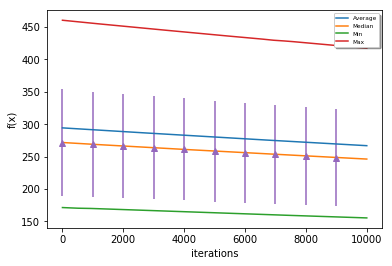

In [216]:
plotGraphs10D(total_history32)

In [160]:
print("Optimal founds:")
for x in optimal_found32:
    print(Griewank(np.array(x)))

Optimal founds:
244.03925339896077
243.96615247266433
276.51725304115377
155.4635039484971
198.96335233730053
379.0139958882693
279.79639961781646
248.40324484104428
229.14837693307894
220.88322994140125
216.4051767521898
366.42961869386755
244.198750361594
252.39356977639332
190.836179044502
324.571098239687
235.13484246182952
203.75391919665384
296.63507045658827
295.3664538074329
285.9164685364602
205.2475142875077
178.87008980317995
359.35250181388017
212.33086644246598
417.3276118288779
156.7628917977414
326.6667254617576
386.27308841979357
377.97576885530975


In [161]:
tf.reset_default_graph()

## Griewank with Momentum

### 2-Dimensions

In [146]:
sess = tf.Session()
optimal_found18 = []

total_history18 = []

for i in range(num_experiments):
    x = []
    for i in range( 2 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 1000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history18.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found18.append(optimum)
    
total_history18 = np.array(total_history18)
print(total_history18.shape)
sess.close()

(30, 1000)


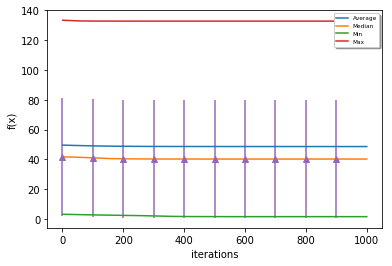

In [217]:
plotGraphs(total_history18)

In [148]:
print("Optimal founds:")
for x in optimal_found18:
    print(Griewank(np.array(x)))

Optimal founds:
82.57345441362719
113.52425640765907
3.787401211320363
3.282170751355669
29.363515176989605
73.17185006141659
88.71194448719699
50.54923689818776
24.57020322390624
83.15776438031325
36.33082230087612
115.85654395464687
11.708872061732535
1.5979915797401043
73.7377221552271
46.755794480224615
6.390369488855956
23.279005237252306
4.27104628390984
31.9021150903666
93.26906553683419
97.25141198121064
3.6184087698803364
14.701580976637942
61.701636874013445
12.89025033625106
72.40974815401351
21.729183347651762
44.17947778344655
132.801579428444


### 10-Dimensions

In [162]:
sess = tf.Session()
optimal_found33 = []

total_history33 = []

for i in range(num_experiments):
    x = []
    for i in range( 10 ):
        x.append(tf.Variable(np.random.random() * 1200 - 600))
        
    sess.run(tf.initialize_all_variables())

    f1 = GriewankTF(x)
    optimum, history_loss = GradientDescentWithMomentum(x, f1, 10000, lr=0.01)
    #total_history += np.array(history_loss)
    total_history33.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found33.append(optimum)
    
total_history33 = np.array(total_history33)
print(total_history33.shape)
sess.close()

(30, 10000)


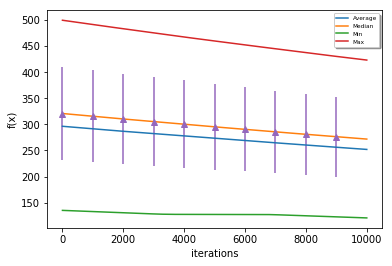

In [218]:
plotGraphs10D(total_history33)

In [ ]:
print("Optimal founds:")
for x in optimal_found33:
    print(Griewank(np.array(x)))

## Griewank with Hill Climbing

### 2-Dimensions

In [53]:
optimal_found19 = []
total_history19 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1200 - 600
    f = Griewank
    optimum, history_loss = HillClimbing(x, f, (-600, 600), num_iterations=1000)
    #total_history += np.array(history_loss)
    total_history19.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found19.append(optimum)

total_history19 = np.array(total_history19)
print(total_history19.shape)

(30, 1000)


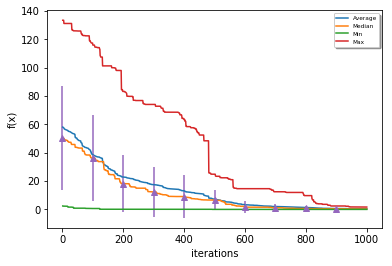

In [219]:
plotGraphs(total_history19)

In [149]:
print("Optimal founds:")
for x in optimal_found19:
    print(Griewank(np.array(x)))

Optimal founds:
0.5039335647698924
0.12729143550751743
1.193580098382148
0.09943959058219387
0.28711730460287277
0.13863302912564524
0.024259057013445995
0.47048831915606293
0.12255084770721925
0.05053569376009448
0.17791951462682376
0.2240586070675309
0.018712427232495776
0.05028248564766058
0.5044363641203223
0.2725580689464069
0.6821241744934613
0.5692477583856627
0.42505995853840506
0.6865904105151065
0.1339521733399589
1.6800402233968408
1.1524800505647566
0.9112537180031954
0.14221376402790764
0.8500386031134741
0.4513956299112968
0.03760549154853354
0.903372363728451
0.3381636927786754


### 10-Dimensions

In [164]:
optimal_found34 = []
total_history34 = []

for i in range(num_experiments):
    x = np.random.random(10) * 1200 - 600
    f = Griewank
    optimum, history_loss = HillClimbing(x, f, (-600, 600), num_iterations=10000)
    #total_history += np.array(history_loss)
    total_history34.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found34.append(optimum)

total_history34 = np.array(total_history34)
print(total_history34.shape)

(30, 10000)


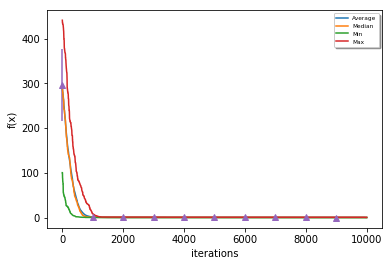

In [220]:
plotGraphs10D(total_history34)

In [173]:
print("Optimal founds:")
for x in optimal_found31:
    print(Griewank(np.array(x)))

Optimal founds:
1.001851785364826
1.0320632822892615
1.0061833443913244
1.008626661680048
1.0314655492589635
1.0345134506317897
1.162381077744317
1.0108239470239502
1.0276075312743693
1.4783448211320724
0.0
1.0105310581702487
1.0120772553233053
1.0240350240987688
0.3936426026103389
1.2244984961145775
0.0
6.870989036899533e+16
1.105448142329147
1.0055627808097027
1.1402441433906478
1.813024892776068
1.003706043685338
1.0166611338059215
1.0024692535333881
1.329930251323846
2.87045834569104
726049054785537.0
1.017901013706155
9717670597361664.0


## Griewank with Simulated Annealing

### 2-Dimensions

In [55]:
optimal_found20 = []
total_history20 = []

for i in range(num_experiments):
    x = np.random.random(2) * 1200 - 600
    f = Griewank
    optimum, history_loss = SimulatedAnnealing(x, f, (-600, 600), t_max=1000)
    #total_history += np.array(history_loss)
    total_history20.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found20.append(optimum)

total_history20 = np.array(total_history20)
print(total_history20.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 1000)


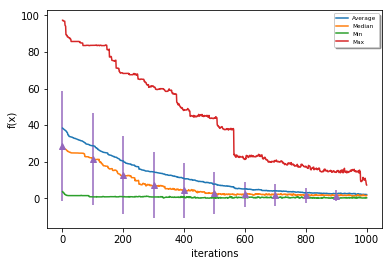

In [221]:
plotGraphs(total_history20)

In [ ]:
print("Optimal founds:")
for x in optimal_found20:
    print(Griewank(np.array(x)))

### 10-Dimensions

In [168]:
optimal_found35 = []
total_history35 = []

for i in range(num_experiments):
    x = np.random.random(10) * 1200 - 600
    f = Griewank
    optimum, history_loss = SimulatedAnnealing(x, f, (-600, 600), t_max=10000)
    #total_history += np.array(history_loss)
    total_history35.append(np.array(history_loss))
    #plt.plot([i for i in range(1,1001)], history_loss, 'b')
    optimal_found35.append(optimum)

total_history35 = np.array(total_history35)
print(total_history35.shape)

/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


(30, 10000)


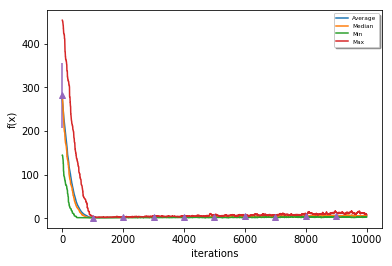

In [222]:
plotGraphs10D(total_history35)

In [171]:
print("Optimal founds:")
for x in optimal_found35:
    print(Griewank(np.array(x)))

Optimal founds:
7.684124362860122
4.436867591822427
6.614497674157311
5.573724440537035
7.307834185982853
3.557218318261039
5.9196012812837635
2.9948200965788794
5.352689462824344
8.12599312431935
7.330926474994447
7.41045354297031
6.818606060997306
4.351956062706145
8.136122411125092
7.052316317393112
8.632179401967944
5.169713804904888
4.022832589396983
5.006712528246931
8.05776892561765
4.26655662160179
4.377478533006963
3.5656288113822523
5.270068631193948
5.5506990572076536
5.524621490762693
4.924195383983792
7.214578550719934
5.354785873574276


# Saving the models

In [172]:
total_histories = [total_history, total_history2, total_history3, total_history4, total_history5, total_history6, total_history7, total_history8, total_history9, total_history10, total_history11, total_history12, total_history13, total_history14, total_history15, total_history16, total_history17, total_history18, total_history19, total_history20, total_history21, total_history22, total_history23, total_history24, total_history25, total_history26, total_history27, total_history28, total_history29, total_history30, total_history31, total_history32, total_history33, total_history34, total_history35]
optimal_founds = [optimal_found1, optimal_found2, optimal_found3, optimal_found4, optimal_found5, optimal_found6, optimal_found7, optimal_found8, optimal_found9, optimal_found10, optimal_found11, optimal_found12, optimal_found13, optimal_found14, optimal_found15, optimal_found16, optimal_found17, optimal_found18, optimal_found19, optimal_found20, optimal_found21, optimal_found22, optimal_found23, optimal_found24, optimal_found25, optimal_found26, optimal_found27, optimal_found28, optimal_found29, optimal_found30, optimal_found31, optimal_found32, optimal_found33, optimal_found34, optimal_found35]

pickle.dump(total_histories, open("total_histories.pickle", 'wb'))
pickle.dump(optimal_founds, open("optimal_founds.pickle", 'wb'))

In [157]:
total_histories = pickle.load(open("total_histories.pickle", 'rb'))
optimal_founds = pickle.load(open("optimal_founds.pickle", 'rb'))

In [47]:
total_history = total_histories[0]
total_history2 = total_histories[1]
total_history3 = total_histories[2]
total_history4 = total_histories[3]
total_history5 = total_histories[4]
total_history6 = total_histories[5]
total_history7 = total_histories[6]
total_history8 = total_histories[7]
total_history9 = total_histories[8]
total_history10 = total_histories[9]
total_history11 = total_histories[10]
total_history12 = total_histories[11]
total_history13 = total_histories[12]
total_history14 = total_histories[13]
total_history15 = total_histories[14]
total_history16 = total_histories[15]
total_history17 = total_histories[16]
total_history18 = total_histories[17]
total_history19 = total_histories[18]
total_history20 = total_histories[19]
total_history21 = total_histories[20]
total_history22 = total_histories[21]
total_history23 = total_histories[22]
total_history24 = total_histories[23]
total_history25 = total_histories[24]
total_history26 = total_histories[25]
total_history27 = total_histories[26]

optimal_found1 = optimal_founds[0]
optimal_found2 = optimal_founds[1]
optimal_found3 = optimal_founds[2]
optimal_found4 = optimal_founds[3]
optimal_found5 = optimal_founds[4]
optimal_found6 = optimal_founds[5]
optimal_found7 = optimal_founds[6]
optimal_found8 = optimal_founds[7]
optimal_found9 = optimal_founds[8]
optimal_found10 = optimal_founds[9]
optimal_found11 = optimal_founds[10]
optimal_found12 = optimal_founds[11]
optimal_found13 = optimal_founds[12]
optimal_found14 = optimal_founds[13]
optimal_found15 = optimal_founds[14]
optimal_found16 = optimal_founds[15]
optimal_found17 = optimal_founds[16]
optimal_found18 = optimal_founds[17]
optimal_found19 = optimal_founds[18]
optimal_found20 = optimal_founds[19]
optimal_found21 = optimal_founds[20]
optimal_found22 = optimal_founds[21]
optimal_found23 = optimal_founds[22]
optimal_found24 = optimal_founds[23]
optimal_found25 = optimal_founds[24]
optimal_found26 = optimal_founds[25]
optimal_found27 = optimal_founds[26]

In [84]:
print(len(optimal_found23[0]))

10000


In [42]:
rosenbrockNewton2 = []
sess = tf.Session()
iterations = 100
dimensions = 2
for i in range( 5 ):
    x = []
    for j in range( dimensions ):
        x.append(tf.Variable(np.random.random() * 4096 - 2048))
    sess.run(tf.initialize_all_variables())
    f1 = tf.reduce_sum( [100 * (tf.pow( x[i + 1] - tf.pow(x[i], 2), 2)) + tf.pow( x[i] - 1, 2) for i in range( dimensions - 1 )] )
    rosenbrockNewton2.append( NewtonRaphson( x, f1, iterations ) )
sess.close()

InvalidArgumentError: Input is not invertible.
	 [[Node: MatrixInverse_1 = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](stack_7)]]

Caused by op 'MatrixInverse_1', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-f24bded38cdb>", line 11, in <module>
    rosenbrockNewton2.append( NewtonRaphson( x, f1+0.00001, iterations ) )
  File "<ipython-input-7-76e9e36c9281>", line 3, in NewtonRaphson
    hessian_inv = tf.matrix_inverse(hessian)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 1049, in matrix_inverse
    "MatrixInverse", input=input, adjoint=adjoint, name=name)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/home/woom05/Documents/deeplearning-venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Input is not invertible.
	 [[Node: MatrixInverse_1 = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](stack_7)]]


In [41]:
x = []
sess = tf.Session()
for j in range( dimensions ):
    x.append(tf.Variable(2.0))
sess.run(tf.initialize_all_variables())
f1 = tf.reduce_sum( [100.0 * (tf.pow( x[i + 1] - tf.pow(x[i], 2), 2)) + tf.pow( x[i] - 1, 2) for i in range( dimensions - 1 )] )
sess.run(tf.initialize_all_variables())
print(sess.run(f1+0.0001))
sess.close()


401.0001


In [34]:
tf.reset_default_graph()